# Probabilistic Programming 0: Check installation

This notebook lets you test out your installation of Jupyter and Julia. It will also automatically download all the packages you need for the course, precompile them and check if they run correctly.

In [1]:
# Check correct Julia version (will throw error if false)
@assert VERSION == v"1.6.3"

In [ ]:
# Set up workspace (downloads and installs necessary packages)
using Pkg
Pkg.activate("./workspace/")
Pkg.instantiate();

In [3]:
# Test ForneyLab (will throw errors if inference failed)
using ForneyLab

graph = FactorGraph()

@RV μ ~ GaussianMeanVariance(0.0, 1.0)
@RV x ~ GaussianMeanVariance(μ, 1.0)
placeholder(x, :x)

algorithm = messagePassingAlgorithm(μ, id=:μ)
source_code = algorithmSourceCode(algorithm)
eval(Meta.parse(source_code))

data = Dict(:x => 3.0)
marginals = Dict()
stepμ!(data, marginals)

@assert typeof(marginals) == Dict{Any,Any}
@assert marginals[:μ] == ProbabilityDistribution(Univariate,GaussianWeightedMeanPrecision, xi=3.0, w=2.0)

┌ Info: Precompiling ForneyLab [9fc3f58a-c2cc-5bff-9419-6a294fefdca9]
└ @ Base loading.jl:1342


┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1342


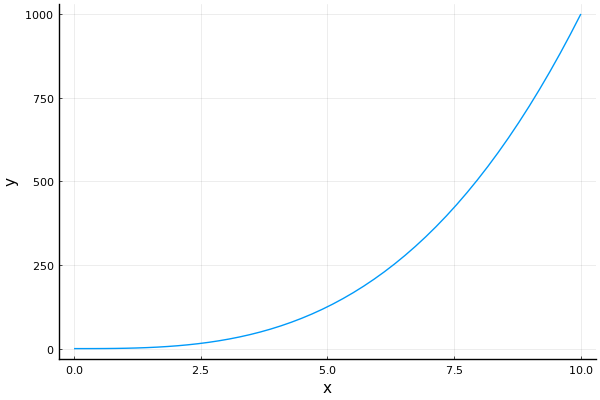

In [4]:
# Test plotting
using Plots
pyplot()

x = range(0, stop=10, length=50)
y = x.^3

plot(x, y, label="", xlabel="x", ylabel="y")

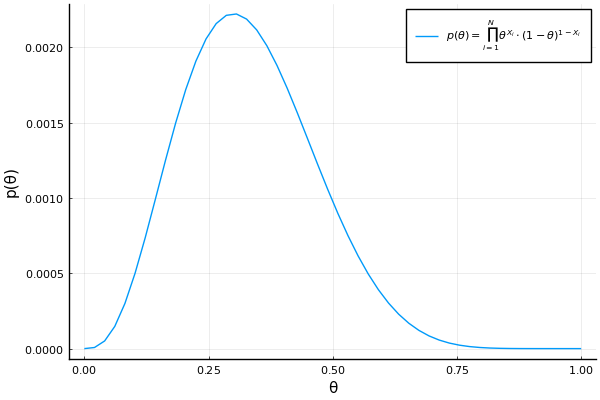

In [5]:
# Test Unicode characters in plots and LaTeXString
using LaTeXStrings

θ = range(0, stop=1, length=50)
pθ = θ.^3 .* (1 .- θ).^7

plot(θ, pθ, xlabel="θ", ylabel="p(θ)", label=L"p(θ) = \prod_{i=1}^{N} θ^{X_i} \cdot (1-\theta)^{1 - X_i}")

In [6]:
# Testing data loading and management
using CSV
using DataFrames

df = DataFrame(CSV.File("../datasets/old_faithful.csv"))

,3.600000,79.000000
,Float64,Float64
1,1.8,54.0
2,3.333,74.0
3,2.283,62.0
4,4.533,85.0
5,2.883,55.0
6,4.7,88.0
7,3.6,85.0
8,1.95,51.0
9,4.35,85.0
